#### Imports para entrenamiento, predicción y evaluación del modelo ####


In [44]:
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style('darkgrid')

In [67]:
data_file_path = '/home/mgarcia/Documents/Study/DiploDatos/Exercises/Integrators/Integrator_1/data.csv'
tag_file_path = '/home/mgarcia/Documents/Study/DiploDatos/Exercises/Integrators/Integrator_1/tag.csv'

In [68]:
fulldata = pd.read_csv(data_file_path)
tag = pd.read_csv(tag_file_path)

In [69]:
traffic_columns = [traffic_column for traffic_column in fulldata.columns if traffic_column.startswith("TR")]

In [70]:
len(traffic_columns)

33

#### Data frame solo con datos de tráfico

In [71]:
df_traffic = fulldata[traffic_columns].copy()

In [72]:
df_traffic.head()

,TRD_M1,TRD_M2,TRD_M3,TRD_STR_M1,TRD_STR_M2,TRD_STR_M3,TRD_SN_M1,TRD_SN_M2,TRD_SN_M3,TRD_IM_M1,...,TRV_ONNET_DUR_M3,TRV_OFFNET_DUR_M1,TRV_OFFNET_DUR_M2,TRV_OFFNET_DUR_M3,TRV_LCL_DUR_M1,TRV_LCL_DUR_M2,TRV_LCL_DUR_M3,TRV_INTRNTL_DUR_M1,TRV_INTRNTL_DUR_M2,TRV_INTRNTL_DUR_M3
0,15.09,5.06,1.00,12538,1121,866,0,38,0,526,...,1.67,8.33,21.95,1.13,147.87,210.55,2.80,0.0,0.0,0.0
1,0.00,0.00,0.00,0,0,0,0,0,0,0,...,0.00,2.27,4.12,0.62,2.27,4.12,0.62,0.0,0.0,0.0
2,0.42,0.00,0.09,57,0,0,0,0,0,244,...,0.68,8.00,3.28,0.20,9.38,3.28,0.88,0.0,0.0,0.0
3,0.14,0.00,0.00,7,0,0,65,0,0,54,...,0.00,0.00,0.00,0.00,1.17,0.00,0.00,0.0,0.0,0.0
4,1.80,3.90,0.88,667,2078,83,128,110,9,562,...,12.05,0.00,0.08,0.00,0.00,0.08,12.05,0.0,0.0,0.0


#### Corroborar si algun datao es NaN o null

In [73]:
any(df_traffic.isna().sum() != 0) or any(df_traffic.isnull().sum() != 0)

False

# Selección de columnas

In [74]:
df_traffic.corr()

,TRD_M1,TRD_M2,TRD_M3,TRD_STR_M1,TRD_STR_M2,TRD_STR_M3,TRD_SN_M1,TRD_SN_M2,TRD_SN_M3,TRD_IM_M1,...,TRV_ONNET_DUR_M3,TRV_OFFNET_DUR_M1,TRV_OFFNET_DUR_M2,TRV_OFFNET_DUR_M3,TRV_LCL_DUR_M1,TRV_LCL_DUR_M2,TRV_LCL_DUR_M3,TRV_INTRNTL_DUR_M1,TRV_INTRNTL_DUR_M2,TRV_INTRNTL_DUR_M3
TRD_M1,1.000000,0.819897,0.706444,0.880530,0.686740,0.589018,0.680411,0.576677,0.504866,0.593411,...,0.107154,0.134440,0.102743,0.077624,0.169570,0.137804,0.113377,-0.000773,-0.002232,-0.004701
TRD_M2,0.819897,1.000000,0.812299,0.704101,0.849376,0.686593,0.568637,0.671875,0.563763,0.512410,...,0.121957,0.113338,0.122002,0.090125,0.141943,0.161491,0.129081,-0.000854,0.001362,-0.001865
TRD_M3,0.706444,0.812299,1.000000,0.602125,0.678701,0.877616,0.503848,0.570486,0.665991,0.457710,...,0.147253,0.094316,0.101494,0.105583,0.121747,0.138817,0.155561,-0.004722,-0.003314,-0.003169
TRD_STR_M1,0.880530,0.704101,0.602125,1.000000,0.764232,0.642544,0.371446,0.312305,0.267777,0.308190,...,0.086616,0.076968,0.058092,0.039714,0.129685,0.105906,0.089213,0.000450,0.000482,-0.001999
TRD_STR_M2,0.686740,0.849376,0.678701,0.764232,1.000000,0.751853,0.282610,0.333055,0.274304,0.254250,...,0.096966,0.056978,0.065639,0.042894,0.107090,0.121827,0.099642,-0.000372,0.002228,-0.000502
TRD_STR_M3,0.589018,0.686593,0.877616,0.642544,0.751853,1.000000,0.249587,0.284675,0.334460,0.220446,...,0.114020,0.043531,0.051642,0.053253,0.088952,0.102413,0.117524,-0.003120,-0.001942,-0.002279
TRD_SN_M1,0.680411,0.568637,0.503848,0.371446,0.282610,0.249587,1.000000,0.844782,0.749215,0.455462,...,0.035954,0.088585,0.066330,0.049818,0.073528,0.056111,0.040727,-0.005767,-0.007249,-0.007717
TRD_SN_M2,0.576677,0.671875,0.570486,0.312305,0.333055,0.284675,0.844782,1.000000,0.844078,0.403161,...,0.043548,0.076208,0.078627,0.058169,0.059258,0.068211,0.049022,-0.006036,-0.006423,-0.007252
TRD_SN_M3,0.504866,0.563763,0.665991,0.267777,0.274304,0.334460,0.749215,0.844078,1.000000,0.359763,...,0.051734,0.063119,0.064802,0.066499,0.044817,0.052227,0.057883,-0.006818,-0.007302,-0.006473
TRD_IM_M1,0.593411,0.512410,0.457710,0.308190,0.254250,0.220446,0.455462,0.403161,0.359763,1.000000,...,0.119294,0.159099,0.125445,0.102146,0.183313,0.153102,0.127902,-0.002409,-0.006056,-0.006909


Plotear un heatmap de 33x33 es inviable, vamos a separar por tipo de dato:
1. Tráfico de datos
   * Total
   * Streaming
   * Redes sociales
   * Internet
2. Número de SMS
3. Tiempo de llamadas de voz
Y cada uno de estos los vamos a agrupar por por mes, para evaluar la relación que hay entre un mismo tipo de consumo por mes.

# Correlación de variables de tráfico

## Tráfico de datos

#### Tráfico de datos agrupados por tipo

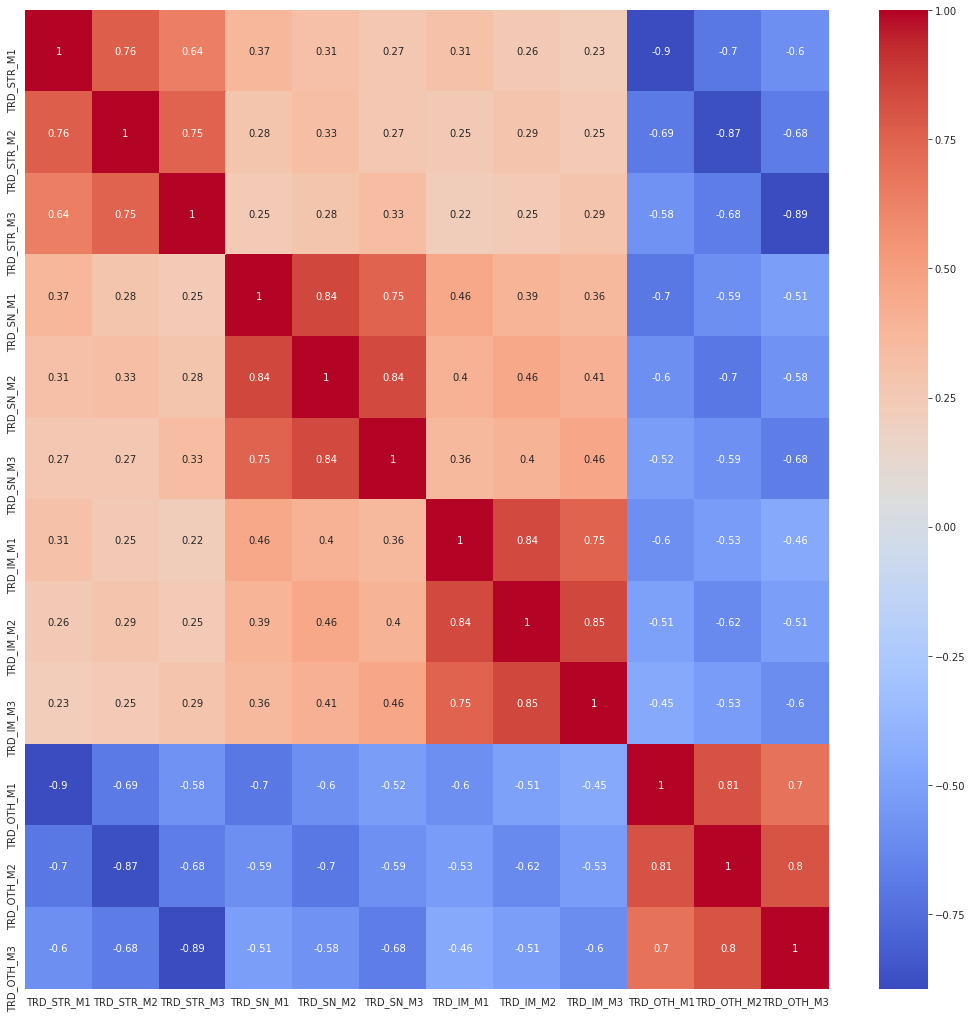

In [75]:
# FIXME: Corroborar que estas columnas tienen el total de los datos
total_data_columns = ['TRD_M1', 'TRD_M2', 'TRD_M3']
df_traffic_data_columns = [traffic_column for traffic_column in traffic_columns 
                           if traffic_column.startswith("TRD") 
                           and traffic_column not in  total_data_columns]
df_traffic_data_corr  = df_traffic[df_traffic_data_columns].corr()
# df_traffic_data_corr
plt.figure(figsize=(18, 18))
sns.heatmap(df_traffic_data_corr, annot=True, cmap='coolwarm')

Función que devuelve dos últimos elementos de iterable, en este caso mes de las columnas

In [76]:
get_month = lambda x: x[-2:]

#### Tráfico de datos agrupados por mes

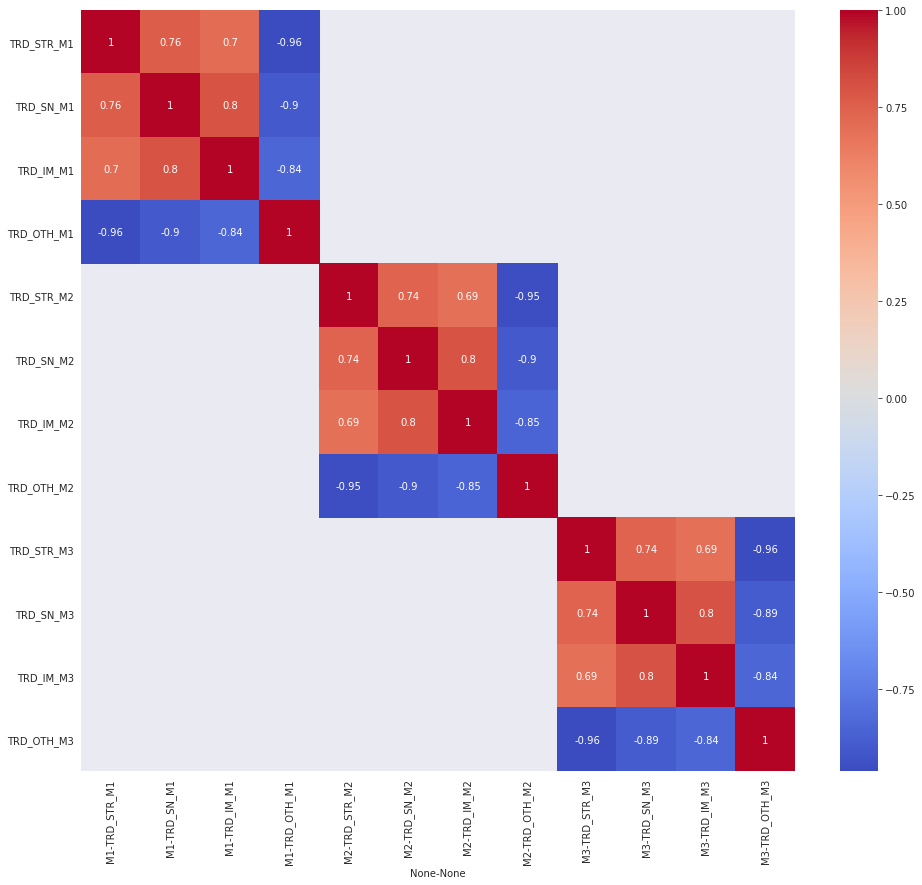

In [77]:
by_month_traffic_data_corr = df_traffic_data_corr.groupby(by=get_month, axis=1).corr()
# by_month_traffic_data_corr
plt.figure(figsize=(16, 14))
sns.heatmap(by_month_traffic_data_corr, annot=True, cmap='coolwarm')

### Las variables de consumo de datos agrupadas por mes tienen una correlación bastante alta por lo que se los puede agrupar por mes.

-----------

## Número de SMS

### Número de SMS agrupados por tipo

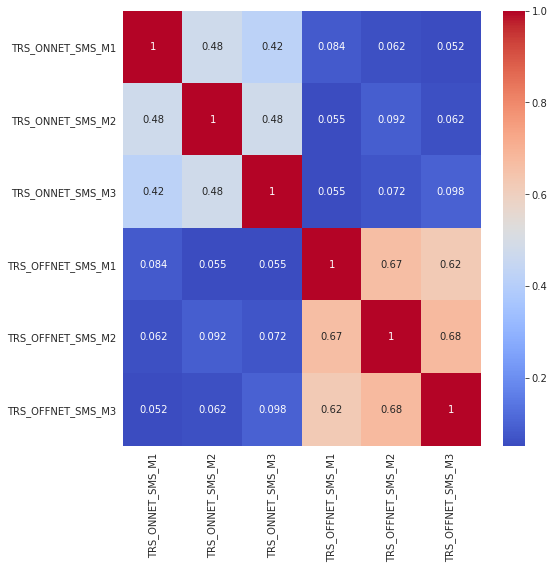

In [78]:
df_n_sms_columns = [traffic_column for traffic_column in traffic_columns if traffic_column.startswith("TRS")]
df_n_sms_corr  = df_traffic[df_n_sms_columns].corr()
# df_n_sms_corr
plt.figure(figsize=(8, 8))
sns.heatmap(df_n_sms_corr, annot=True, cmap='coolwarm')

### Número de SMS agrupados por mes

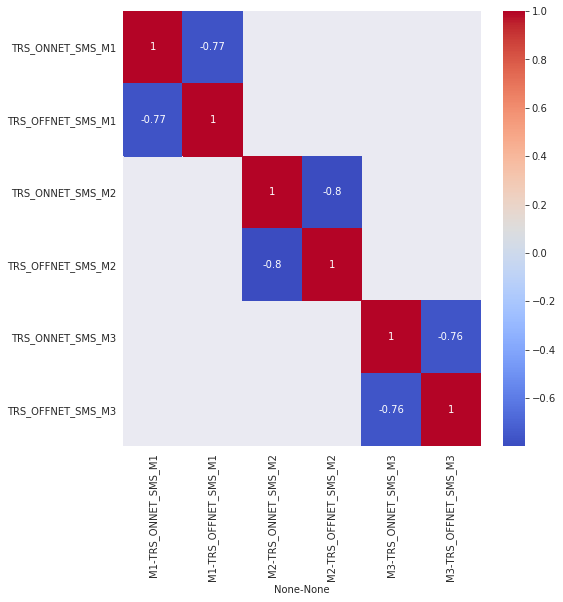

In [79]:
by_month_n_sms_corr = df_n_sms_corr.groupby(by=get_month, axis=1).corr()
# by_month_n_sms_corr
plt.figure(figsize=(8, 8))
sns.heatmap(by_month_n_sms_corr, annot=True, cmap='coolwarm')

In [80]:
df_traffic[df_n_sms_columns].describe()

,TRS_ONNET_SMS_M1,TRS_ONNET_SMS_M2,TRS_ONNET_SMS_M3,TRS_OFFNET_SMS_M1,TRS_OFFNET_SMS_M2,TRS_OFFNET_SMS_M3
count,319222.000000,319222.000000,319222.000000,319222.000000,319222.000000,319222.000000
mean,0.173415,0.185037,0.191791,1.216655,1.198780,1.216179
std,0.949936,0.983975,1.002220,2.403954,2.400983,2.459793
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,26.000000,36.000000,36.000000,37.000000,38.000000,30.000000


### Como los datos de SMS están acumulados en torno a cero, se descartarán estas columnas

-------------------------------------

## Llamadas de voz

### Llamadas por voz agrupadas por tipo

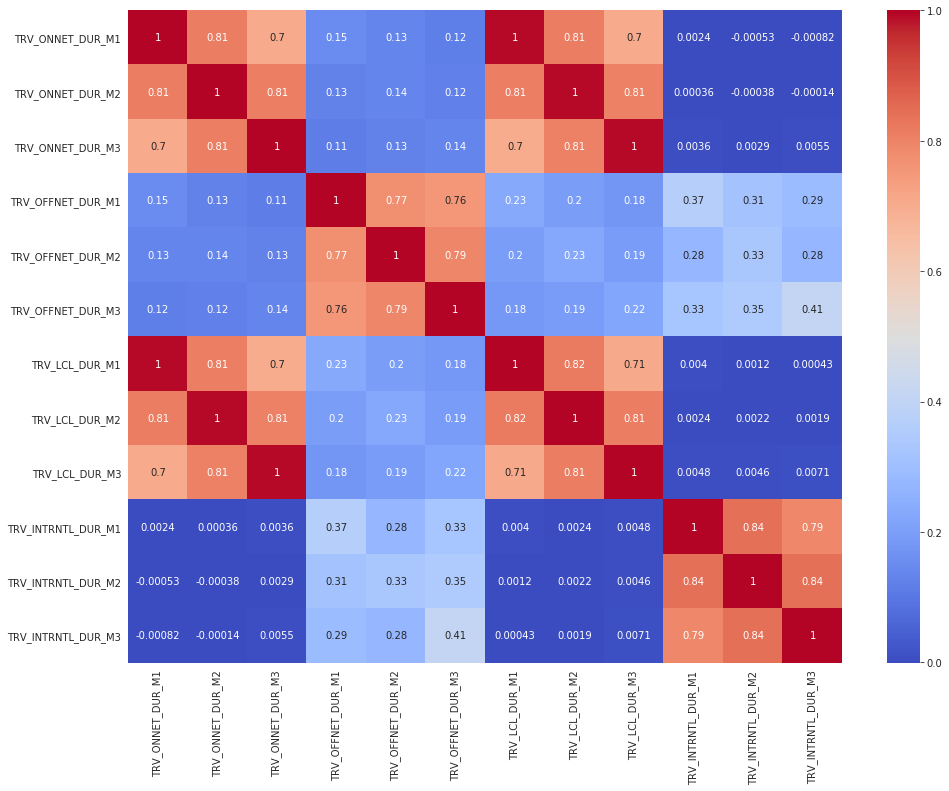

In [81]:
df_voice_minutes_columns = [traffic_column for traffic_column in traffic_columns if traffic_column.startswith("TRV")]
df_voice_minutes_corr = df_traffic[df_voice_minutes_columns].corr()
# df_n_sms_corr
plt.figure(figsize=(16, 12))
sns.heatmap(df_voice_minutes_corr, annot=True, cmap='coolwarm')

### Llamadas por voz agrupadas por mes

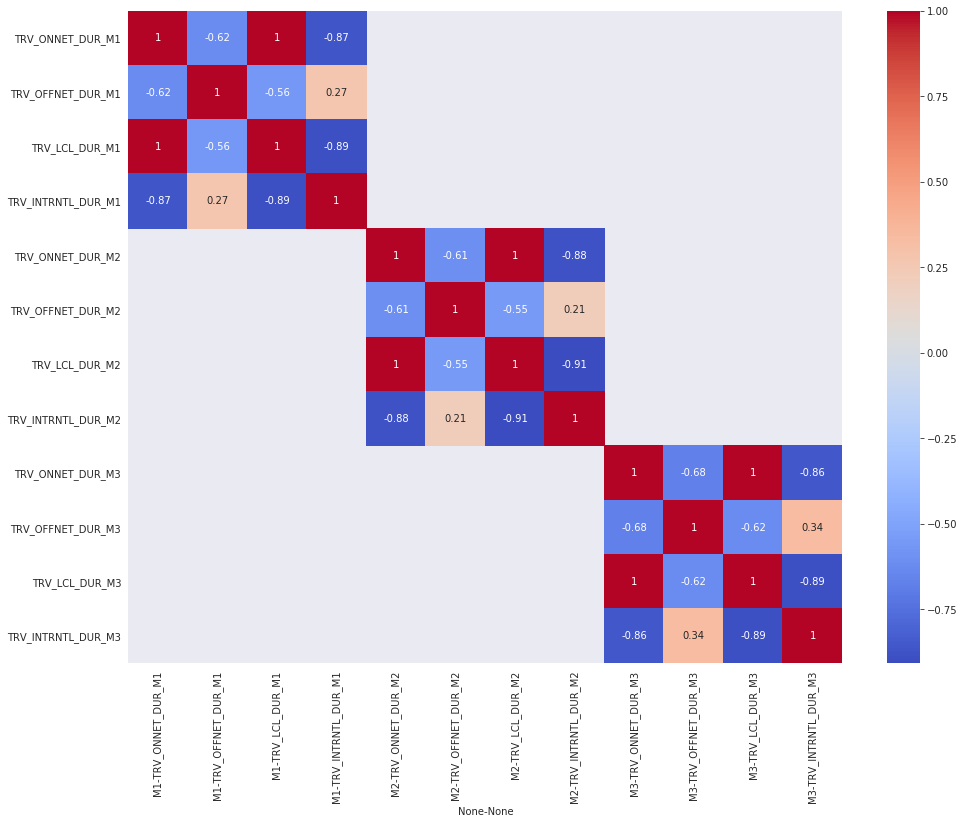

In [82]:
by_month_voice_minutes_corr = df_voice_minutes_corr.groupby(by=get_month, axis=1).corr()
# by_month_n_sms_corr
plt.figure(figsize=(16, 12))
sns.heatmap(by_month_voice_minutes_corr, annot=True, cmap='coolwarm')

### Las llamamdas tienen también una alta correlación entre sí por mes, por lo que se podrían agrupar por columnas por mes

--------------------------

# Outliers

## Tráfico de datos

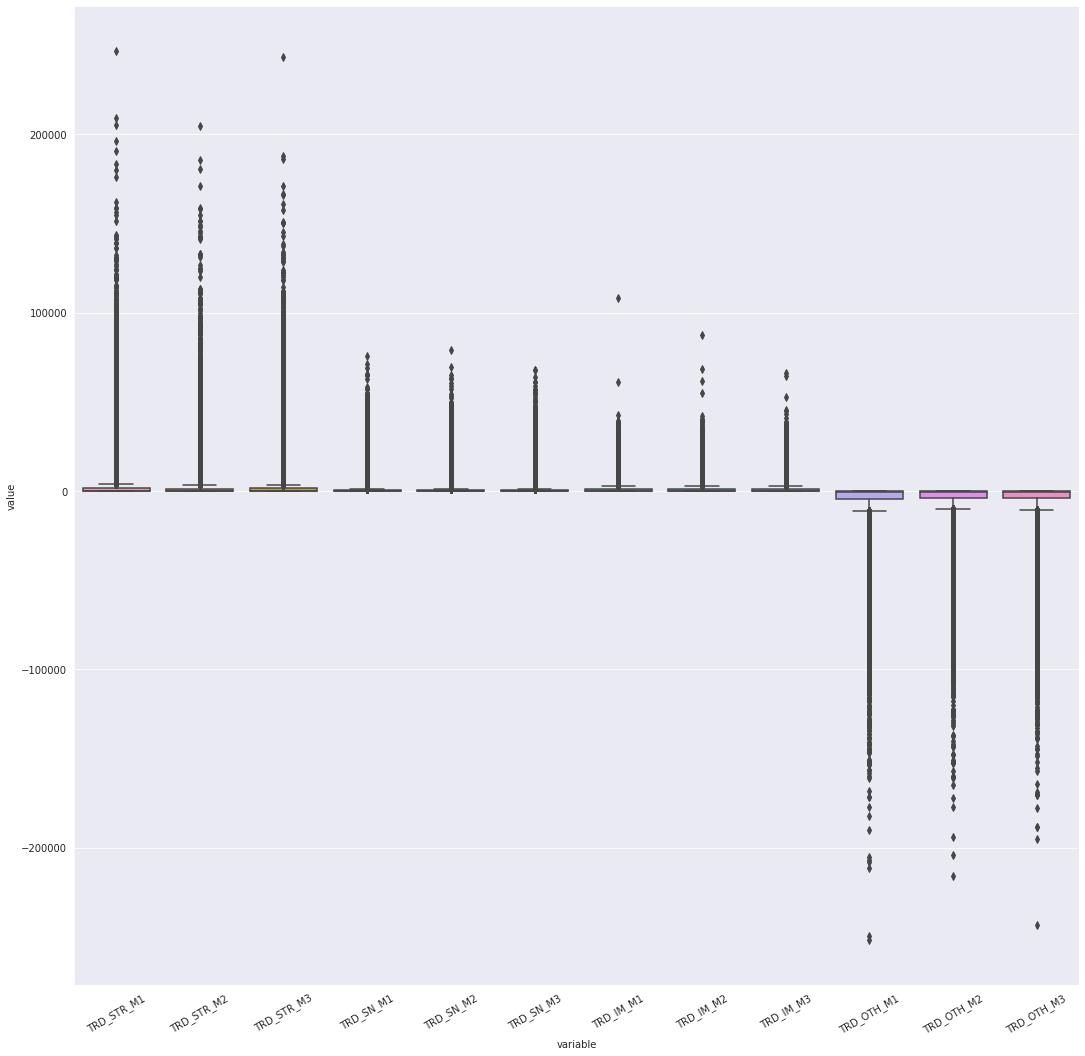

In [83]:
plt.figure(figsize=(18,18))
ax = sns.boxplot(x="variable", y="value", data=pd.melt(df_traffic[df_traffic_data_columns]))
ax = ax.set_xticklabels(ax.get_xticklabels(),rotation=30)

## Llamadas por voz

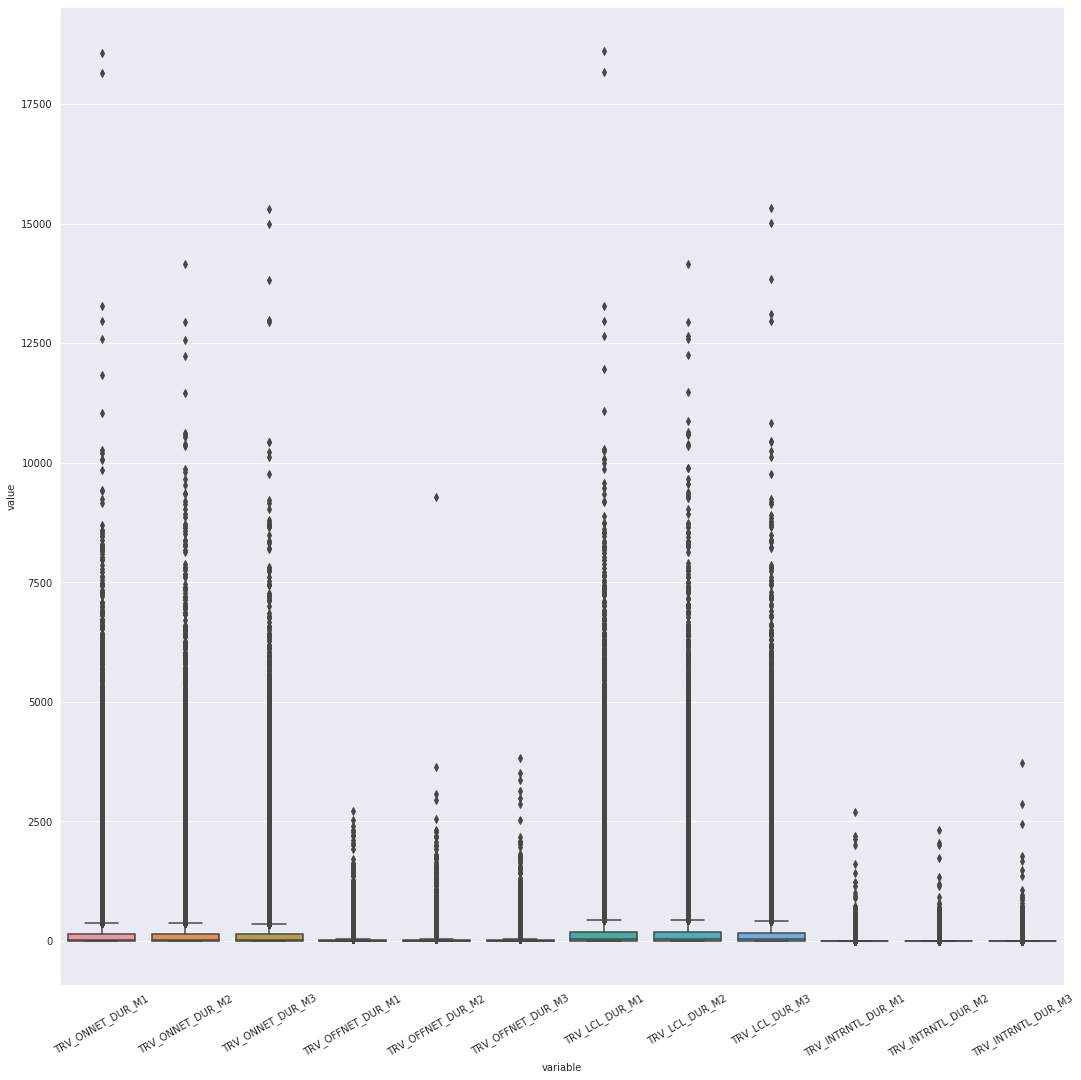

In [84]:
plt.figure(figsize=(18,18))
ax = sns.boxplot(x="variable", y="value", data=pd.melt(df_traffic[df_voice_minutes_columns]))
ax = ax.set_xticklabels(ax.get_xticklabels(),rotation=30)

## Sacando outliers

In [85]:
df_traffic_copy = df_traffic.copy()

In [86]:
df_traffic_data = pd.DataFrame()
for column in df_traffic[df_traffic_data_columns]:
    Q1 = df_traffic[column].quantile(0.25)
    Q3 = df_traffic[column].quantile(0.75)
    IQR = Q3 - Q1
    df_traffic_data[column] = np.where((df_traffic[column] < (Q1 - 1.5 * IQR)) | (df_traffic[column] > (Q3 + 1.5 * IQR)), df_traffic[column].median(), df_traffic[column])


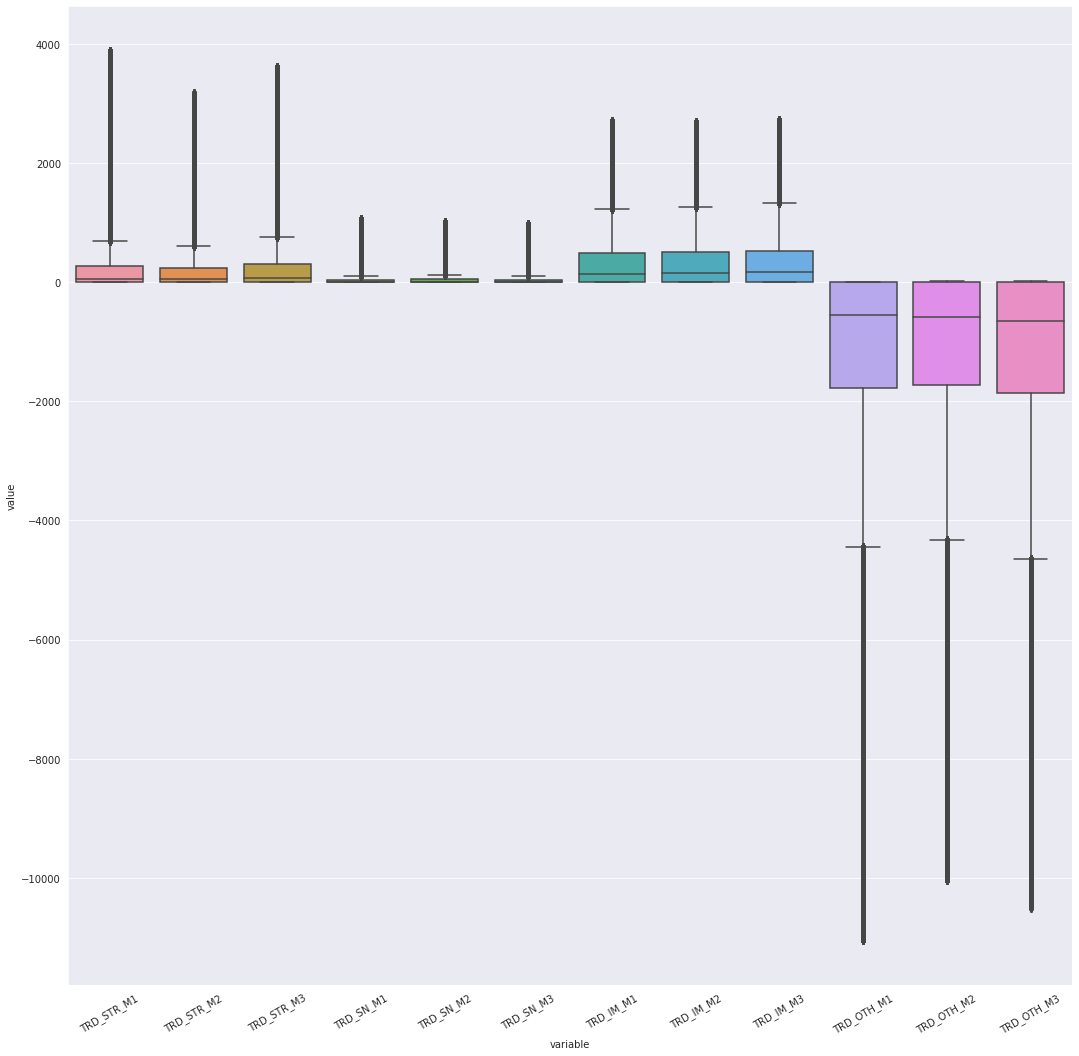

In [87]:
plt.figure(figsize=(18,18))
ax = sns.boxplot(x="variable", y="value", data=pd.melt(df_traffic_data))
ax = ax.set_xticklabels(ax.get_xticklabels(),rotation=30)

In [88]:
df_voice_data = pd.DataFrame()
for column in df_traffic[df_voice_minutes_columns]:
    Q1 = df_traffic[column].quantile(0.25)
    Q3 = df_traffic[column].quantile(0.75)
    IQR = Q3 - Q1
    df_voice_data[column] = np.where((df_traffic[column] < (Q1 - 1.5 * IQR)) | (df_traffic[column] > (Q3 + 1.5 * IQR)), df_traffic[column].median(), df_traffic[column])


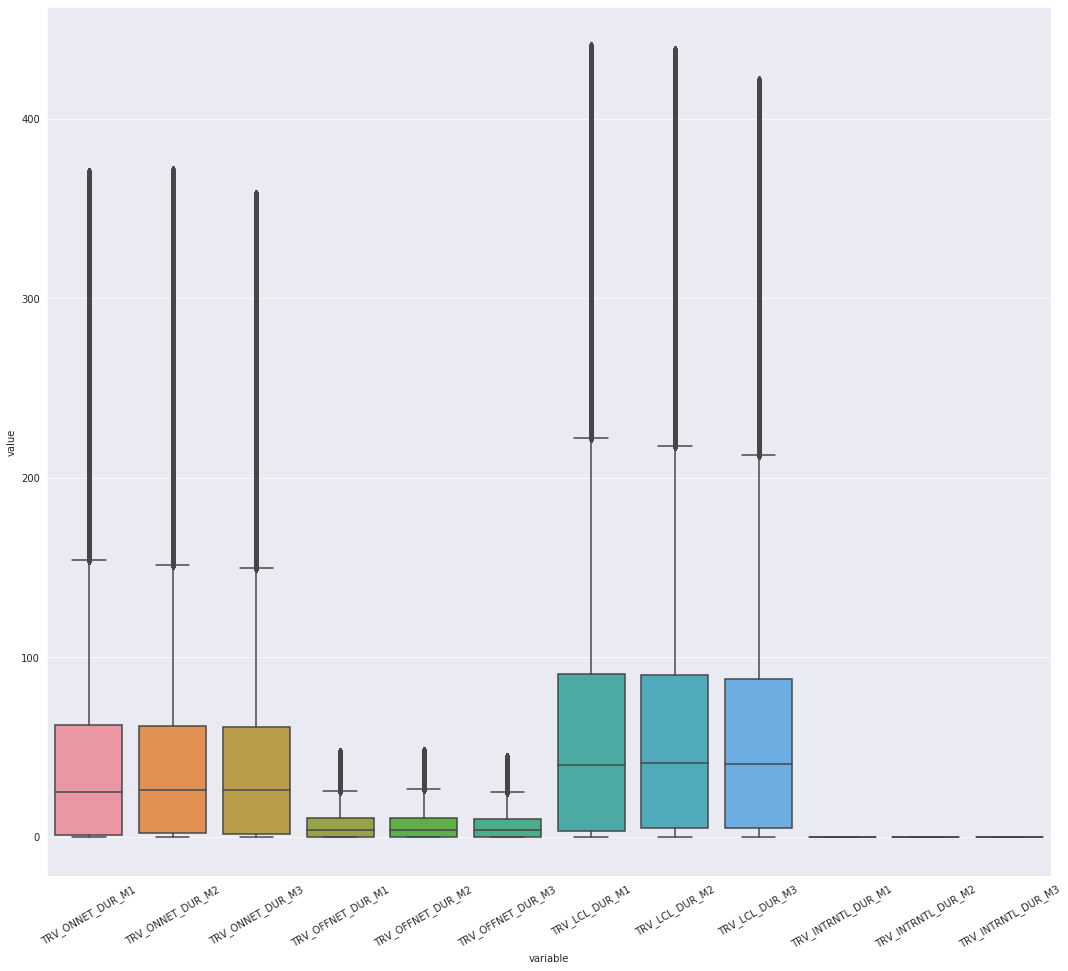

In [89]:
plt.figure(figsize=(18,16))
ax = sns.boxplot(x="variable", y="value", data=pd.melt(df_voice_data))
ax = ax.set_xticklabels(ax.get_xticklabels(),rotation=30)

### Sacando datos de fulldata

In [90]:
fulldata.drop(columns=traffic_columns, inplace=True)

In [91]:
df_traffic.drop(columns=df_n_sms_columns, inplace=True)

In [94]:
fulldata.join(other=df_traffic)

,SUSCRIBER_KEY,FECHA_CORTE,LAT_PROV_BTS,LON_PROV_BTS,LAT_CITY_BTS,LON_CITY_BTS,VALUE_SEGMENT,SEGMENTATION,MICROSEGMENTATION,SOURCE,...,TRV_ONNET_DUR_M3,TRV_OFFNET_DUR_M1,TRV_OFFNET_DUR_M2,TRV_OFFNET_DUR_M3,TRV_LCL_DUR_M1,TRV_LCL_DUR_M2,TRV_LCL_DUR_M3,TRV_INTRNTL_DUR_M1,TRV_INTRNTL_DUR_M2,TRV_INTRNTL_DUR_M3
0,E_63734494_20190215,08-SEP-19,8.58480,-82.38850,-82.43330,8.43330,3 - SILVER,2-PD,PD1,NEW,...,1.67,8.33,21.95,1.13,147.87,210.55,2.80,0.0,0.0,0.0
1,E_66977552_20190518,08-SEP-19,8.58480,-82.38850,-82.43330,8.43330,4 - BRONZE,7-LOW,LOW3,NEW,...,0.00,2.27,4.12,0.62,2.27,4.12,0.62,0.0,0.0,0.0
2,E_69159695_20180116,08-SEP-19,8.12310,-81.07550,-78.16140,8.65525,3 - SILVER,6-OH,LOW4,NEW,...,0.68,8.00,3.28,0.20,9.38,3.28,0.88,0.0,0.0,0.0
3,E_65255730_20190416,08-SEP-19,9.08320,-79.59240,-79.51973,8.99360,3 - SILVER,7-LOW,LOW3,NEW,...,0.00,0.00,0.00,0.00,1.17,0.00,0.00,0.0,0.0,0.0
4,E_67893872_20161201,08-SEP-19,9.08320,-79.59240,-79.51973,8.99360,3 - SILVER,3-DO,DO3,NEW,...,12.05,0.00,0.08,0.00,0.00,0.08,12.05,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319217,E_66690182_20190121,08-SEP-19,9.41650,-82.52070,-82.52000,9.43000,4 - BRONZE,7-LOW,LOW4,NEW,...,1.12,0.00,0.00,2.32,0.00,0.00,3.43,0.0,0.0,0.0
319218,E_65347728_20171017,08-SEP-19,9.08320,-79.59240,-79.51973,8.99360,3 - SILVER,3-DO,VD3,NEW,...,177.43,0.47,7.82,14.67,133.85,194.52,192.10,0.0,0.0,0.0
319219,E_68063707_20150701,08-SEP-19,8.79528,-80.14711,-79.65000,8.95000,3 - SILVER,6-OH,OH2,NEW,...,36.33,1.00,1.07,0.42,92.50,29.83,36.75,0.0,0.0,0.0
319220,E_67206080_20181010,08-SEP-19,7.86810,-77.83670,-77.67270,8.13930,4 - BRONZE,7-LOW,VD1,NEW,...,433.30,0.00,0.00,18.17,0.00,0.00,451.47,0.0,0.0,0.0
